In [1]:
from proj1_helpers import *
from tools import *
from implementations import *

# Data manipulation support
import numpy as np
import pandas as pd

# Graphics support
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
seed = 10

## Import data

In [2]:
DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'

In [3]:
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Data analysis

In [4]:
analysis_data = pd.DataFrame(tX)

In [5]:
# Check the discrete number of jets according to the column PRI_jet_num
analysis_data[22].value_counts()

0.0    99913
1.0    77544
2.0    50379
3.0    22164
Name: 22, dtype: int64

In [6]:
# Check which columns have missing data
for cols in analysis_data:
    test_missing = (analysis_data[cols] == -999.000)
    print('Column {} has {} missing data'.format(cols,test_missing.sum()))

Column 0 has 38114 missing data
Column 1 has 0 missing data
Column 2 has 0 missing data
Column 3 has 0 missing data
Column 4 has 177457 missing data
Column 5 has 177457 missing data
Column 6 has 177457 missing data
Column 7 has 0 missing data
Column 8 has 0 missing data
Column 9 has 0 missing data
Column 10 has 0 missing data
Column 11 has 0 missing data
Column 12 has 177457 missing data
Column 13 has 0 missing data
Column 14 has 0 missing data
Column 15 has 0 missing data
Column 16 has 0 missing data
Column 17 has 0 missing data
Column 18 has 0 missing data
Column 19 has 0 missing data
Column 20 has 0 missing data
Column 21 has 0 missing data
Column 22 has 0 missing data
Column 23 has 99913 missing data
Column 24 has 99913 missing data
Column 25 has 99913 missing data
Column 26 has 177457 missing data
Column 27 has 177457 missing data
Column 28 has 177457 missing data
Column 29 has 0 missing data


After checking out all the columns which have missing data, we started to compare these columns in terms of the number of jets. We found out that there are some internal rules between the number of jets and several missing data; Thus, we decided to split the set into individual sets for each jet number.

### Density plots of the features

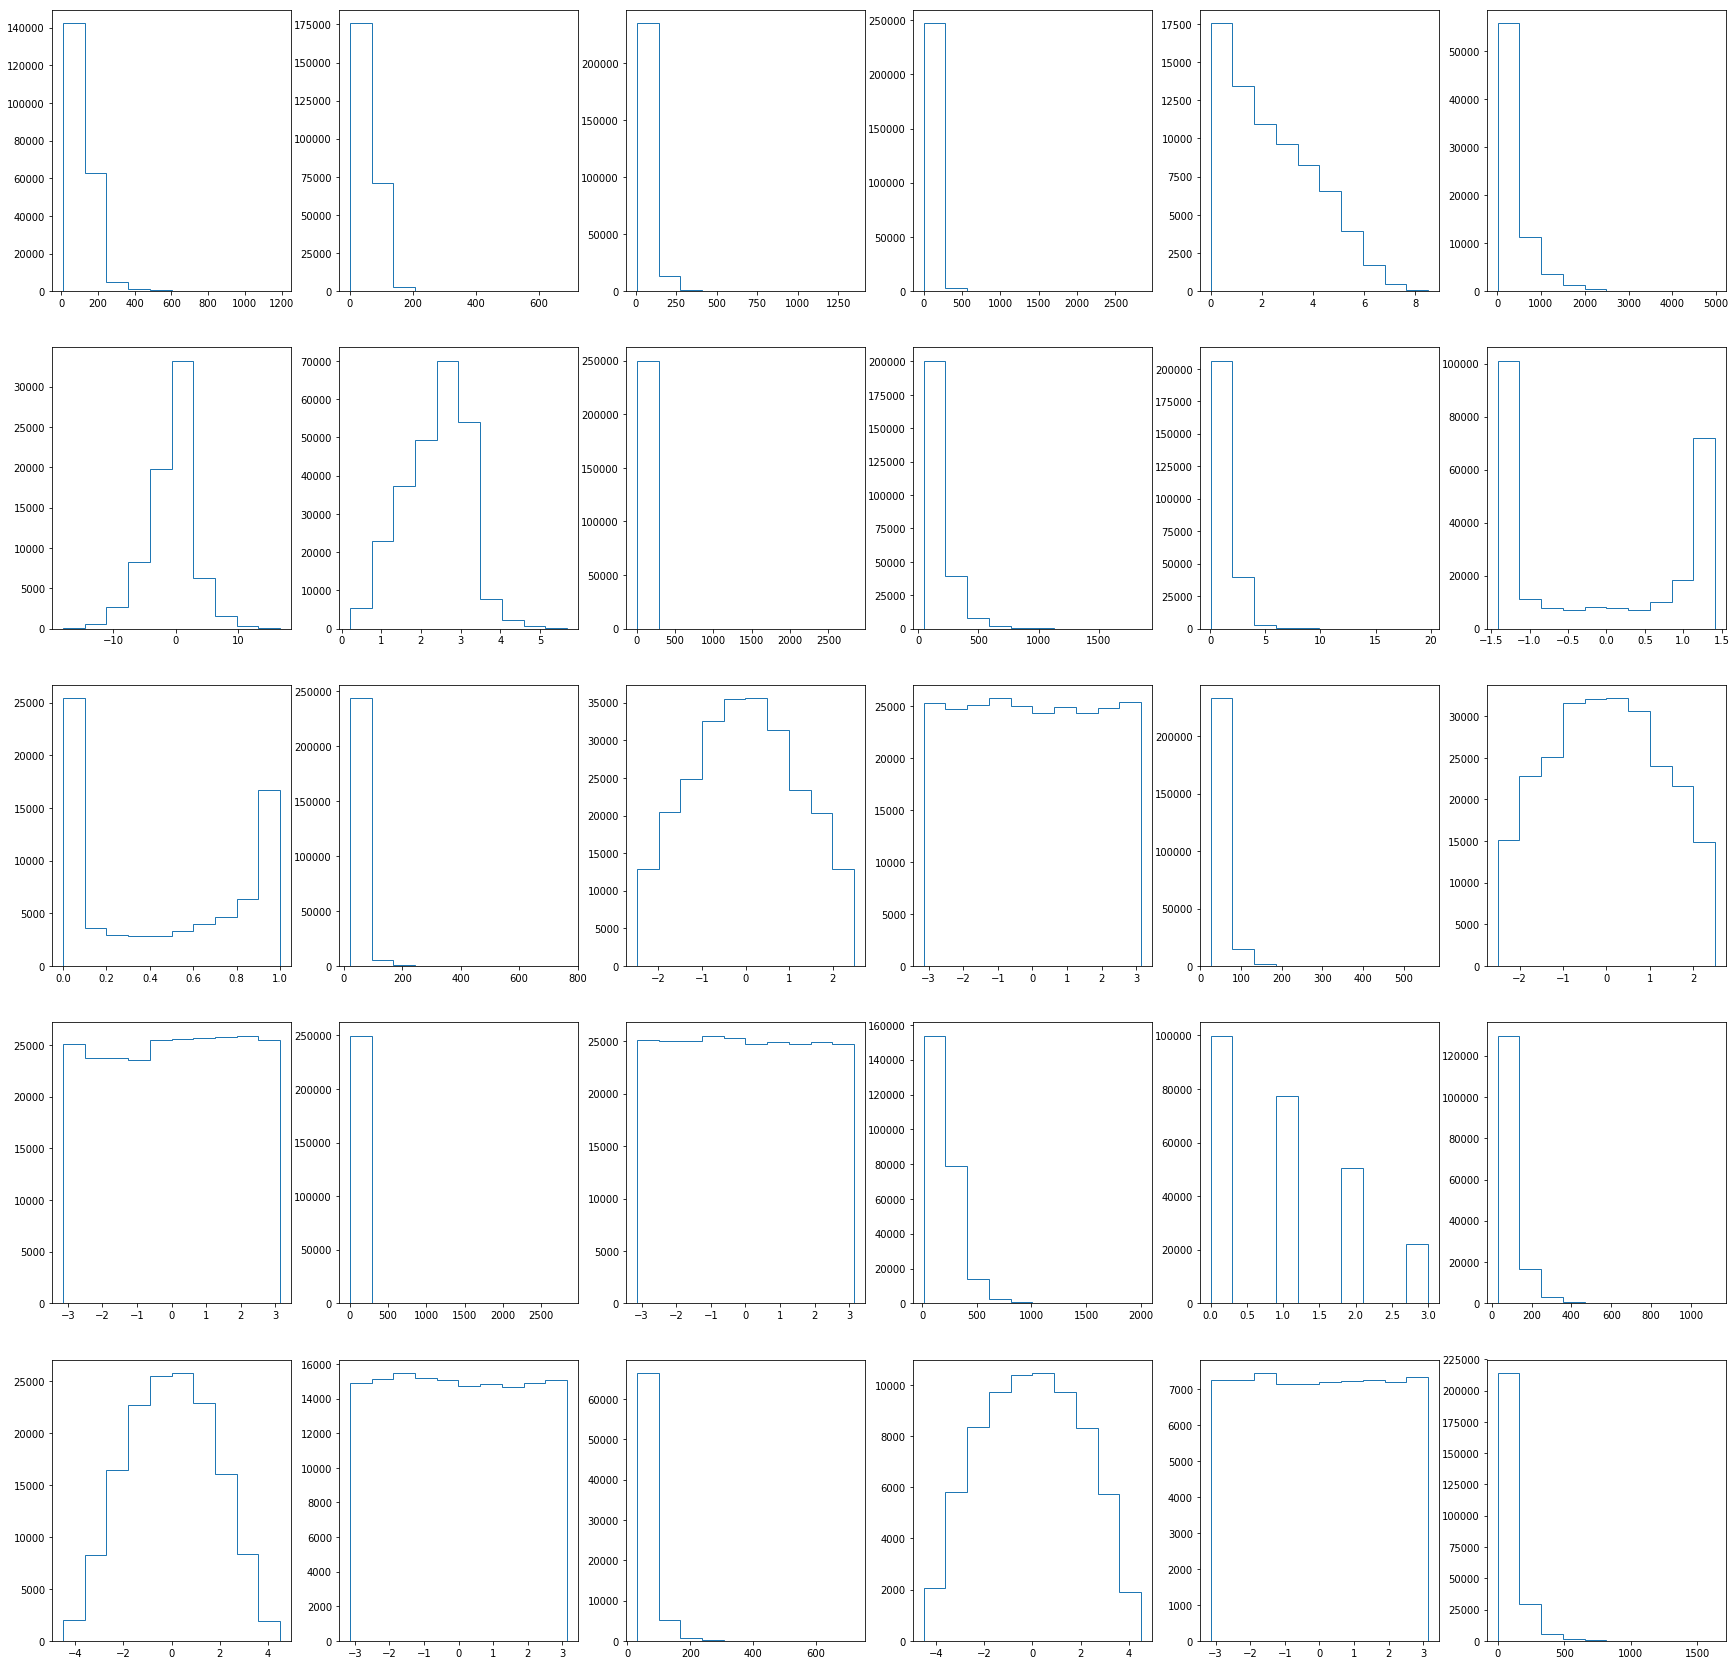

In [7]:
num_features = np.shape(tX)[1] 
_,a = plt.subplots(5,6,figsize = (30,30))
a = a.ravel()
for i,temp in enumerate(a):
    column = tX[:,i]
    temp_data = column[np.where(column != -999)]
    temp.hist(temp_data,histtype = 'step')

### 5 Phi features

From the density plots of all the 30 features above, we can easily find out there are 5 features whose plots are very different from the others. After checking the name of these features by index, we found that all of them are Phi variables. These Phi variables showed uniform densities indicating that these features are not very useful for the prediction. We can drop these variables without any loss of fidelity against the information from the original data set.

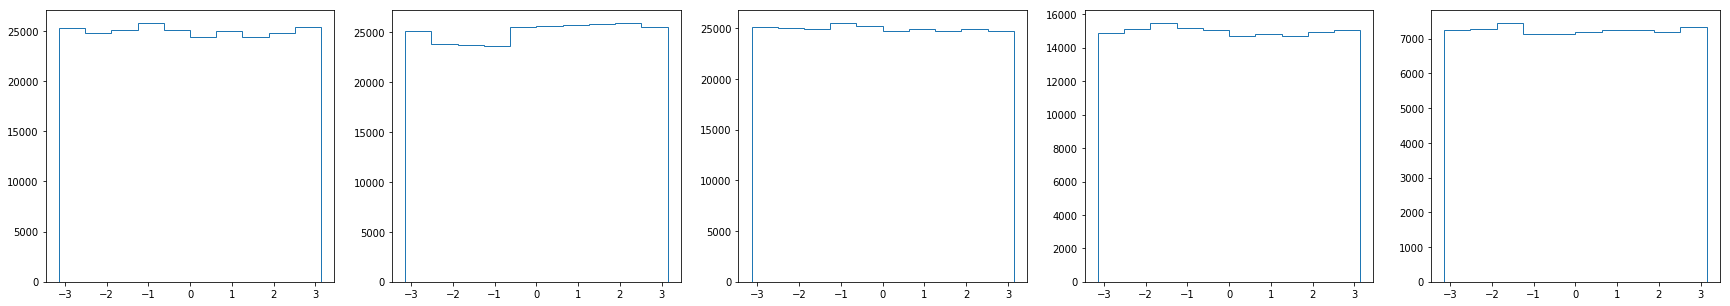

In [8]:
phi_features_index = [15,18,20,25,28]
_,a = plt.subplots(1,5,figsize = (30,5))
a = a.ravel()
for i,temp in enumerate(a):
    column = tX[:,phi_features_index[i]]
    temp_data = column[np.where(column != -999)]
    temp.hist(temp_data,histtype = 'step')

### Data pre-processing

For data pre-processing, we decided to replaced -999 by the most frequent value of the column if there exists at least one non -999 value in the column. Otherwise, by 0 which means we discarded this feature. Then, we implemented the logorithm inverse to all the positive columns in order to reduce the range of the values. Finally, we standardize the whole dataset by subtract the mean and divide by the standard deviation for each feature.

In [9]:
def replace_missing_data_by_frequent_value(x_train, x_test):
    for i in range(x_train.shape[1]):
        if np.any(x_train[:, i] == -999):

            # Collect all the indices of non -999 value
            temp_train = (x_train[:, i] != -999)
            temp_test = (x_test[:, i] != -999)

            # Calculate frequency
            values, counts = np.unique(x_train[temp_train, i], return_counts = True)

            # Replace -999 by the most frequent value of the columns if there exits at least one non -999 value
            if (len(values) > 1):
                x_train[~temp_train, i] = values[np.argmax(counts)]
                x_test[~temp_test, i] = values[np.argmax(counts)]
                
            # Otherwise, discard the column
            else:
                x_train[~temp_train, i] = 0
                x_test[~temp_test, i] = 0
    return x_train, x_test

In [10]:
def process_data(x_train, x_test):
    x_train, x_test = replace_missing_data_by_frequent_value(x_train, x_test)

    # invese logarithm for all the positive value columns
    log_index = [0, 1, 2, 5, 7, 9, 10, 13, 16, 19, 21, 23, 26]
    x_train_log = np.log(1 / (1 + x_train[:, log_index]))
    x_train = np.hstack((x_train, x_train_log))
    x_test_log = np.log(1 / (1 + x_test[:, log_index]))
    x_test = np.hstack((x_test, x_test_log))

    # Standardization
    x_train, mean_train, std_train = standardize(x_train)
    x_test, mean_test, std_test = standardize(x_test, mean_train, std_train)

    # Delete 5 phi features
    x_train = np.delete(x_train, [15,18,20,25,28], 1)
    x_test = np.delete(x_test, [15,18,20,25,28], 1)

    return x_train, x_test

## Cross validation

In [11]:
def cross_validation(y, x, k_indices, k, regression_method, **kwargs):
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)

    y_test = y[test_indice]
    y_train = y[train_indice]
    x_test = x[test_indice]
    x_train = x[train_indice]

    # Data processing
    x_train, x_test = process_data(x_train, x_test)
    
    # Add constant column
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

    weight, loss_train = regression_method(y = y_train, tx = x_train, **kwargs)

    y_train_pred = predict_labels(weight, x_train)
    y_test_pred = predict_labels(weight, x_test)

    accuracy_train = compute_accuracy(y_train_pred, y_train)
    accuracy_test = compute_accuracy(y_test_pred, y_test)

    return accuracy_train, accuracy_test

In [12]:
# Split dataset into three subsets
def group_features_by_jet(x):
    return {  
        0: x[:, 22] == 0,
        1: x[:, 22] == 1,
        2: np.logical_or(x[:, 22] == 2, x[:, 22] == 3)  
    }

In [13]:
def cross_validation_split_data_by_jet_no(y, x, k_indices, k, lambdas, degrees):
    test_indice = k_indices[k]
    train_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)

    all_y_test = y[test_indice]
    all_y_train = y[train_indice]
    all_x_test = x[test_indice]
    all_x_train = x[train_indice]

    # Split data into three subset by jet_no
    dict_jets_train = group_features_by_jet(all_x_train)
    dict_jets_test = group_features_by_jet(all_x_test)

    y_train_pred = np.zeros(len(all_y_train))
    y_test_pred = np.zeros(len(all_y_test))

    for index in range(len(dict_jets_train)):
        x_train = all_x_train[dict_jets_train[index]]
        x_test = all_x_test[dict_jets_test[index]]
        y_train = all_y_train[dict_jets_train[index]]

        # Data processing
        x_train, x_test = process_data(x_train, x_test)
        
        # Build polynomial features
        x_train = build_polynomial_features(x_train, degrees[index])
        x_test = build_polynomial_features(x_test, degrees[index])
        
        # Add constant column 
        x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
        x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

        weight, loss_train = ridge_regression(y = y_train, tx = x_train, lambda_ = lambdas[index])

        y_train_pred[dict_jets_train[index]] = predict_labels(weight, x_train)
        y_test_pred[dict_jets_test[index]] = predict_labels(weight, x_test)

    accuracy_train = compute_accuracy(y_train_pred, all_y_train)
    accuracy_test = compute_accuracy(y_test_pred, all_y_test)

    return accuracy_train, accuracy_test

## Gradient descent

In [14]:
k_fold = 10
gamma = 0.01
max_iters = 1000

k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, least_squares_GD, initial_w = None, max_iters = max_iters, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
    
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.7665688888888889 - Test accuracy : 0.7676
Training accuracy: 0.7680844444444445 - Test accuracy : 0.76016
Training accuracy: 0.7671777777777777 - Test accuracy : 0.77048
Training accuracy: 0.7675688888888889 - Test accuracy : 0.76584
Training accuracy: 0.7669866666666667 - Test accuracy : 0.76964
Training accuracy: 0.7669111111111111 - Test accuracy : 0.76796
Training accuracy: 0.7668577777777777 - Test accuracy : 0.7652
Training accuracy: 0.7671822222222222 - Test accuracy : 0.7682
Training accuracy: 0.7660977777777778 - Test accuracy : 0.76792
Training accuracy: 0.7668133333333333 - Test accuracy : 0.76784
Average test accuracy: 0.7670839999999999
Variance test accuracy: 7.46542400000011e-06


## Stochastic gradient descent

In [15]:
k_fold = 10
gamma = 0.01
max_iters = 1000

k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, least_squares_SGD, initial_w = None, max_iters = max_iters, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.6930933333333333 - Test accuracy : 0.69444
Training accuracy: 0.7145555555555556 - Test accuracy : 0.70936
Training accuracy: 0.7413155555555555 - Test accuracy : 0.7418
Training accuracy: 0.7391111111111112 - Test accuracy : 0.73764
Training accuracy: 0.6172311111111111 - Test accuracy : 0.6164
Training accuracy: 0.7295022222222223 - Test accuracy : 0.7318
Training accuracy: 0.7014622222222222 - Test accuracy : 0.70028
Training accuracy: 0.7348977777777778 - Test accuracy : 0.73588
Training accuracy: 0.7094622222222222 - Test accuracy : 0.70808
Training accuracy: 0.7269955555555555 - Test accuracy : 0.73168
Average test accuracy: 0.710736
Variance test accuracy: 0.0012486477440000008


## Least squares

In [16]:
k_fold = 10

k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, least_squares)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.7748444444444444 - Test accuracy : 0.77364
Training accuracy: 0.7760711111111112 - Test accuracy : 0.7706
Training accuracy: 0.7758666666666667 - Test accuracy : 0.77872
Training accuracy: 0.7759155555555556 - Test accuracy : 0.77352
Training accuracy: 0.7751333333333333 - Test accuracy : 0.77772
Training accuracy: 0.7752088888888888 - Test accuracy : 0.77404
Training accuracy: 0.7755422222222222 - Test accuracy : 0.77236
Training accuracy: 0.7754888888888889 - Test accuracy : 0.77836
Training accuracy: 0.7742311111111111 - Test accuracy : 0.77496
Training accuracy: 0.7747777777777778 - Test accuracy : 0.7782
Average test accuracy: 0.775212
Variance test accuracy: 7.360976000000033e-06


## Ridge regression

In [17]:
k_fold = 10
lambda_ = 0.0001

k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, ridge_regression, lambda_ = lambda_)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.7747644444444445 - Test accuracy : 0.774
Training accuracy: 0.7760533333333334 - Test accuracy : 0.77076
Training accuracy: 0.7757777777777778 - Test accuracy : 0.77844
Training accuracy: 0.7759511111111111 - Test accuracy : 0.7732
Training accuracy: 0.7749777777777778 - Test accuracy : 0.77808
Training accuracy: 0.7751644444444444 - Test accuracy : 0.77388
Training accuracy: 0.7754711111111111 - Test accuracy : 0.77248
Training accuracy: 0.7754577777777778 - Test accuracy : 0.7786
Training accuracy: 0.7740933333333333 - Test accuracy : 0.77488
Training accuracy: 0.7747733333333333 - Test accuracy : 0.77808
Average test accuracy: 0.77524
Variance test accuracy: 7.302719999999938e-06


## Logistic regression

In [18]:
k_fold = 10
gamma = 0.01
max_iters = 1000

k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, logistic_regression, initial_w = None ,max_iters = max_iters, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.7260977777777777 - Test accuracy : 0.72912
Training accuracy: 0.7273244444444444 - Test accuracy : 0.72312
Training accuracy: 0.7259644444444444 - Test accuracy : 0.73204
Training accuracy: 0.72704 - Test accuracy : 0.72116
Training accuracy: 0.7264933333333333 - Test accuracy : 0.729
Training accuracy: 0.7266044444444445 - Test accuracy : 0.72636
Training accuracy: 0.7263377777777777 - Test accuracy : 0.7234
Training accuracy: 0.7263377777777777 - Test accuracy : 0.72952
Training accuracy: 0.7259911111111111 - Test accuracy : 0.728
Training accuracy: 0.7268444444444444 - Test accuracy : 0.72424
Average test accuracy: 0.726596
Variance test accuracy: 1.0976143999999936e-05


## Regularized Logistic Regression

In [19]:
k_fold = 10
gamma = 0.01
max_iters = 1000
lambda_ = 0.0001

k_indices = build_k_indices(y, k_fold, seed)
list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    a_train, a_test = cross_validation(y, tX, k_indices, k, regularized_logistic_regression, initial_w = None ,max_iters = max_iters, lambda_=lambda_, gamma = gamma)
    list_accuracy_train.append(a_train)
    list_accuracy_test.append(a_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.7260977777777777 - Test accuracy : 0.72912
Training accuracy: 0.7273244444444444 - Test accuracy : 0.72312
Training accuracy: 0.7259644444444444 - Test accuracy : 0.73204
Training accuracy: 0.72704 - Test accuracy : 0.72116
Training accuracy: 0.7264933333333333 - Test accuracy : 0.729
Training accuracy: 0.7266044444444445 - Test accuracy : 0.72636
Training accuracy: 0.7263377777777777 - Test accuracy : 0.7234
Training accuracy: 0.7263377777777777 - Test accuracy : 0.72952
Training accuracy: 0.7259911111111111 - Test accuracy : 0.728
Training accuracy: 0.7268444444444444 - Test accuracy : 0.72424
Average test accuracy: 0.726596
Variance test accuracy: 1.0976143999999936e-05


## Ridge regression + Split data by jet_no

In [20]:
k_fold = 10
lambdas = [0.0001, 0.0001, 0.0001]
degrees = [9,10,10]
k_indices = build_k_indices(y, k_fold, seed)

list_accuracy_train = []
list_accuracy_test = []

for k in range(k_fold):
    accuracy_train, accuracy_test = cross_validation_split_data_by_jet_no(y, tX, k_indices, k, lambdas, degrees)
    list_accuracy_train.append(accuracy_train)
    list_accuracy_test.append(accuracy_test)

for i in range(len(list_accuracy_train)):
    print("Training accuracy: {} - Test accuracy : {}".format(list_accuracy_train[i], list_accuracy_test[i]))
print("Average test accuracy: {}".format(np.mean(list_accuracy_test)))
print("Variance test accuracy: {}".format(np.var(list_accuracy_test)))

Training accuracy: 0.8405111111111111 - Test accuracy : 0.83844
Training accuracy: 0.8411822222222223 - Test accuracy : 0.83556
Training accuracy: 0.8403066666666666 - Test accuracy : 0.8408
Training accuracy: 0.8405111111111111 - Test accuracy : 0.83824
Training accuracy: 0.8405155555555556 - Test accuracy : 0.8404
Training accuracy: 0.8413155555555556 - Test accuracy : 0.83384
Training accuracy: 0.8406533333333334 - Test accuracy : 0.83972
Training accuracy: 0.8408488888888889 - Test accuracy : 0.8384
Training accuracy: 0.8406133333333333 - Test accuracy : 0.83792
Training accuracy: 0.8405688888888889 - Test accuracy : 0.84032
Average test accuracy: 0.838364
Variance test accuracy: 4.429263999999994e-06


## Generate the best prediction

In [21]:
print('Start importing data...\n')

DATA_TRAIN_PATH = 'data/train.csv'
DATA_TEST_PATH = 'data/test.csv'

y_train, tx_train, ids_train = load_csv_data(DATA_TRAIN_PATH)
_, tx_test, ids_test = load_csv_data(DATA_TEST_PATH)

lambdas = [0.0001, 0.0001, 0.0001]
degrees = [9, 10, 10]

y_pred = np.zeros(tx_test.shape[0])

dict_jets_train = group_features_by_jet(tx_train)
dict_jets_test = group_features_by_jet(tx_test)

print('Start training...\n')

for index in range(len(dict_jets_train)):
    x_train = tx_train[dict_jets_train[index]]
    x_test = tx_test[dict_jets_test[index]]
    y_train = y[dict_jets_train[index]]

    # Data processing
    x_train, x_test = process_data(x_train, x_test)
    # Build polynomial features
    x_train = build_polynomial_features(x_train, degrees[index])
    x_test = build_polynomial_features(x_test, degrees[index])
    # Add consant column
    x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
    x_test = np.hstack((np.ones((x_test.shape[0], 1)), x_test))

    weight, loss_train = ridge_regression(y_train, x_train, lambdas[index])

    temp_test_pred = predict_labels(weight, x_test)

    y_pred[dict_jets_test[index]] = temp_test_pred
    
print('Start generating prediction files...\n')

OUTPUT_PATH = 'output_ridge_regression_9_10_10.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

print('Finish!')

Start importing data...

Start training...

Start generating prediction files...

Finish!
